[Regression Tree] Test MSE: 6020466791357.16


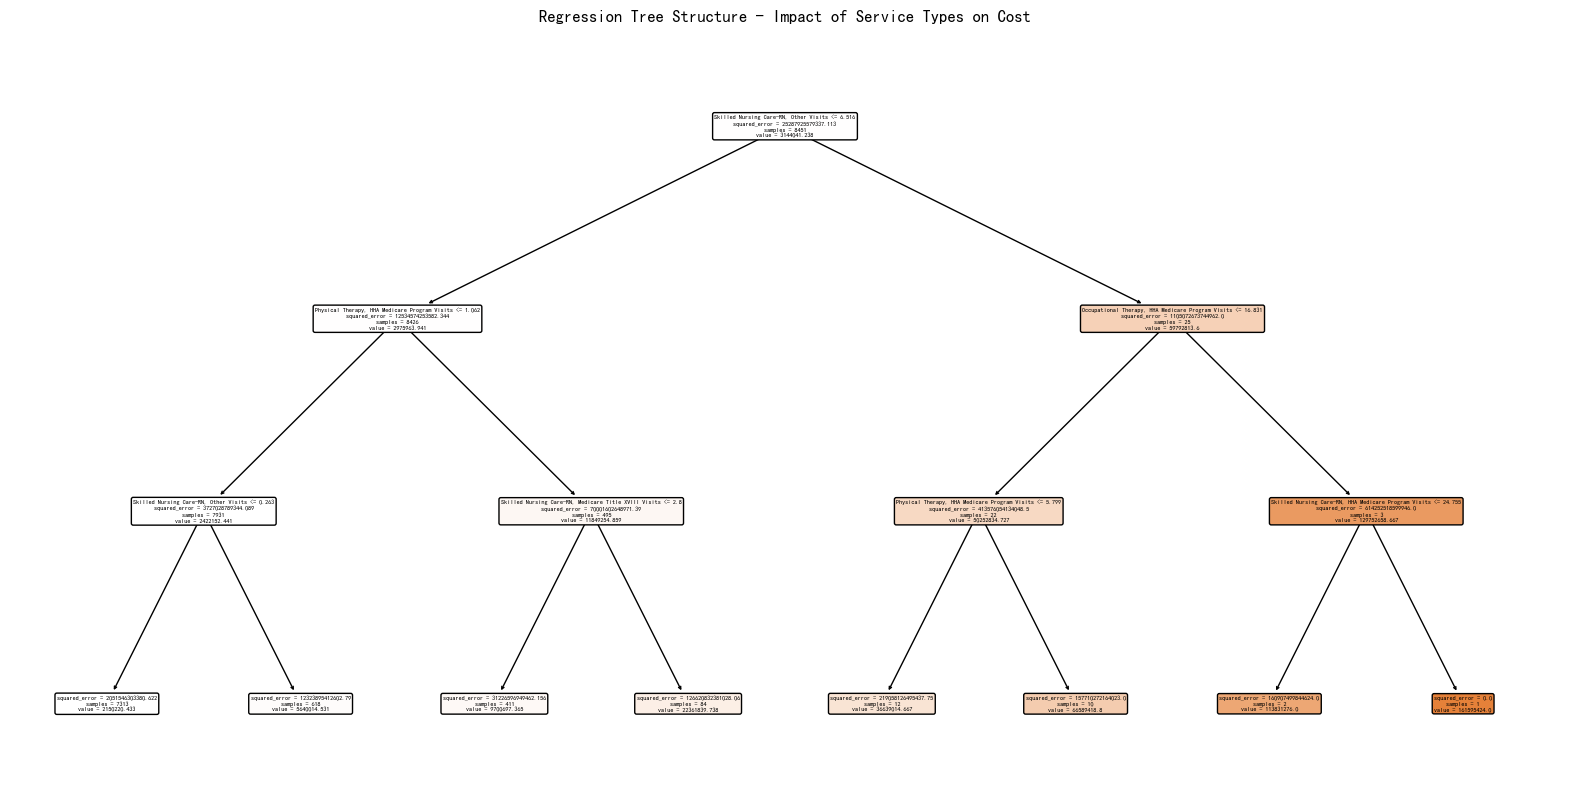

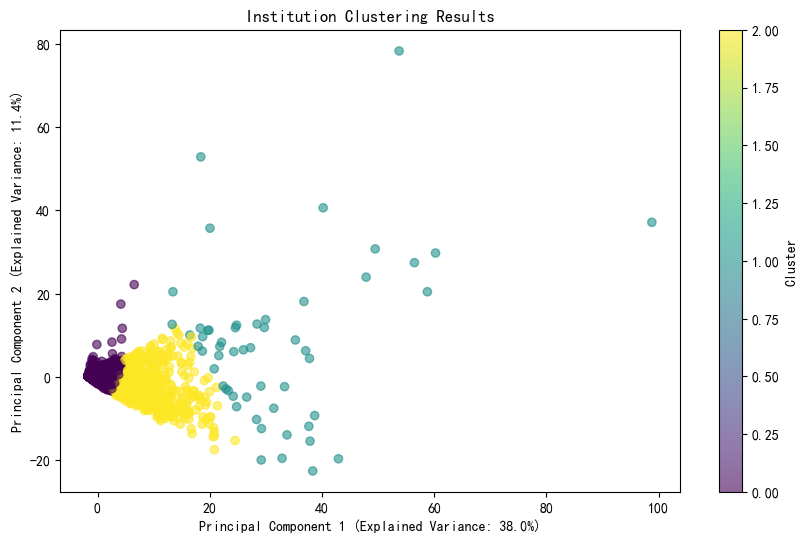


[Cluster Analysis] Service Characteristics by Cluster:
   Skilled Nursing Care-RN, Medicare Title XVIII Visits  \
0                                        1831.679407      
1                                       42302.037037      
2                                        8851.162651      

   Skilled Nursing Care-LPN, Medicare Title XVIII Visits  \
0                                        1463.917161       
1                                       11052.538462       
2                                        5412.876178       

   Physical Therapy, Medicare Title XVIII Visits  \
0                                    1227.053111   
1                                   29137.129630   
2                                    6403.450602   

   Physical Therapy Asst, Medicare Title XVIII Visits  \
0                                         919.667145    
1                                        9706.054054    
2                                        5279.951678    

   Occupational Therapy, Med

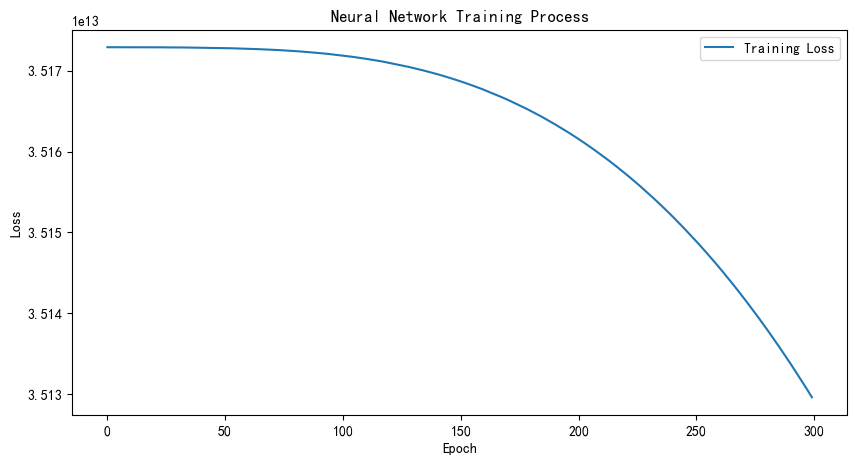

In [9]:
import matplotlib.pyplot as plt

# %% [1] Data Preprocessing
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("CostReporthha_Final_22.csv")

# Select features: number of visits for all service types (excluding "Total" field)
visit_columns = [col for col in df.columns if "Visits" in col and "Total" not in col]
X = df[visit_columns].fillna(0)  # Fill missing values

# Select target: total cost
y = df["Total Cost"].fillna(df["Total Cost"].mean())  # Fill missing values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

#Save standardization tool
import joblib
joblib.dump(scaler, 'scaler.pkl')  



# %% [2] Regression Tree Analysis
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Train regression tree
tree_model = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_model.fit(X_train.numpy(), y_train.numpy().ravel())

# Evaluate
y_pred_tree = tree_model.predict(X_test.numpy())
mse_tree = np.mean((y_test.numpy().ravel() - y_pred_tree) ** 2)
print(f"[Regression Tree] Test MSE: {mse_tree:.2f}")

# Visualize decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=visit_columns, filled=True, rounded=True)
plt.title("Regression Tree Structure - Impact of Service Types on Cost")
plt.show()

# %% [3] Clustering Analysis
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Clustering (assuming 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# PCA dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="viridis", alpha=0.6)
plt.xlabel("Principal Component 1 (Explained Variance: {:.1f}%)".format(pca.explained_variance_ratio_[0]*100))
plt.ylabel("Principal Component 2 (Explained Variance: {:.1f}%)".format(pca.explained_variance_ratio_[1]*100))
plt.title("Institution Clustering Results")
plt.colorbar(label="Cluster")
plt.show()

# Analyze service characteristics for each cluster
print("\n[Cluster Analysis] Service Characteristics by Cluster:")
cluster_summary = df.groupby(clusters)[visit_columns].mean()
print(cluster_summary)

# %% [4] Neural Network Regression (PyTorch Implementation)
import torch.nn as nn
import torch.optim as optim

class CostPredictor(nn.Module):
    def __init__(self, input_size):
        super(CostPredictor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Initialize model
model = CostPredictor(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
train_losses = []
for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}/300, Loss: {loss.item():.4f}")

# Testing
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test)
    test_loss = criterion(y_pred_nn, y_test)
print(f"\n[Neural Network] Test Loss: {test_loss.item():.4f}")

# Plot training loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Neural Network Training Process")
plt.legend()
plt.show()

torch.save(model.state_dict(), 'cost_predictor.pth')  # Save model parameters

D:\softtware2\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


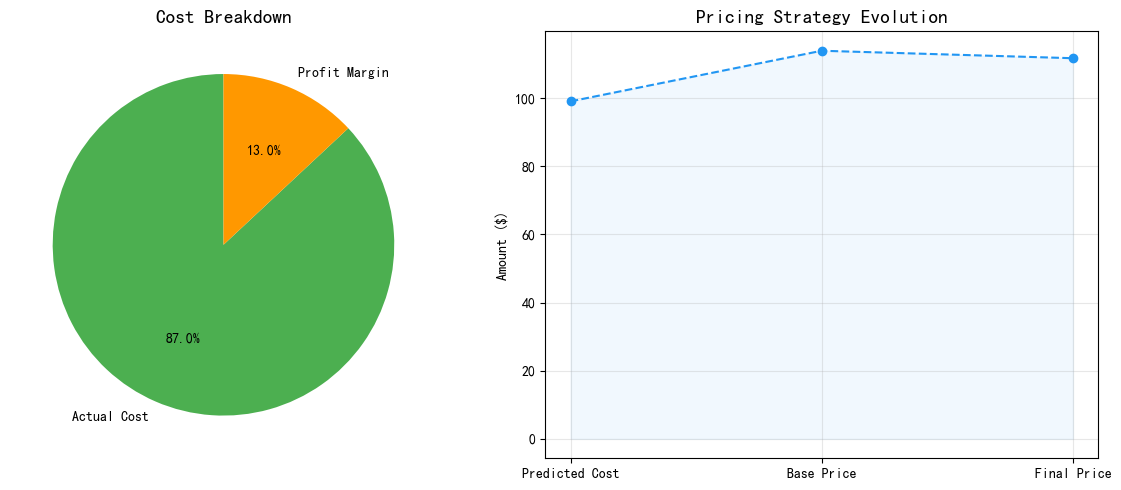


====== Pricing Report ======
Predicted Total Cost: $ 99.04
Base Price (+15% margin): $ 113.89
Adjusted Final Price: $ 111.70

ðŸ’¡ Recommendation:
- If cost exceeds industry average ($3,133,156.06), consider optimizing service mix.
- Current Medicare Ratio: 40%



In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import joblib

# 1. Load dataset
df = pd.read_csv("CostReporthha_Final_22.csv")

# 2. Feature selection
visit_columns = [col for col in df.columns if "Visits" in col and "Total" not in col]

# 3. Load scaler and model
scaler = joblib.load("scaler.pkl")

class CostPredictor(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.layers(x)

model = CostPredictor(len(visit_columns))
model.load_state_dict(torch.load("cost_predictor.pth"))
model.eval()

# 4. Define top services (based on previous analysis)
top_services = [
    'Skilled Nursing Care-RN, Medicare Title XVIII Visits',
    'Physical Therapy, Medicare Title XVIII Visits',
    'Home Health Aide, Medicare Title XVIII Visits'
]

# 5. Auto-generate input values using median
service_values = {col: int(df[col].median()) for col in top_services}
params = {
    'profit_margin': 0.15,
    'medicare_ratio': df['Total HHA Medicare Program Visits'].mean() / df['Total, Total Visits'].mean()
}

# 6. Build full feature vector
full_features = []
for col in visit_columns:
    if col in service_values:
        full_features.append(service_values[col])
    else:
        full_features.append(df[col].median())

# 7. Predict cost
scaled = scaler.transform([full_features])
with torch.no_grad():
    cost = model(torch.tensor(scaled, dtype=torch.float32)).item()

# 8. Pricing logic
base_price = cost * (1 + params['profit_margin'])
adjusted_price = base_price * (0.9 + params['medicare_ratio'] * 0.2)

# 9. Visualization
plt.figure(figsize=(12, 5))

# Pie chart
plt.subplot(1, 2, 1)
plt.title("Cost Breakdown", fontsize=14)
plt.pie(
    [cost, base_price - cost],
    labels=['Actual Cost', 'Profit Margin'],
    colors=['#4CAF50', '#FF9800'],
    autopct='%1.1f%%',
    startangle=90
)

# Pricing strategy evolution
plt.subplot(1, 2, 2)
stages = ['Predicted Cost', 'Base Price', 'Final Price']
values = [cost, base_price, adjusted_price]
plt.plot(stages, values, marker='o', linestyle='--', color='#2196F3')
plt.fill_between(stages, values, alpha=0.2, color='#BBDEFB')
plt.grid(True, alpha=0.3)
plt.title("Pricing Strategy Evolution", fontsize=14)
plt.ylabel("Amount ($)")

plt.tight_layout()
plt.show()

# 10. Text report
print(f'''
====== Pricing Report ======
Predicted Total Cost: $ {cost:,.2f}
Base Price (+{params['profit_margin']:.0%} margin): $ {base_price:,.2f}
Adjusted Final Price: $ {adjusted_price:,.2f}

ðŸ’¡ Recommendation:
- If cost exceeds industry average (${df['Total Cost'].mean():,.2f}), consider optimizing service mix.
- Current Medicare Ratio: {params['medicare_ratio']:.0%}
''')
